In [ ]:
#  !pip install pandas transformers scikit-learn matplotlib seaborn sentencepiece accelerate -q
# torch.set_default_tensor_type(torch.cuda.HalfTensor)

In [1]:
import re
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForCausalLM
from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer, BertForMaskedLM, BertModel
# from transformers import AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

/Users/sabrinasadieh/Code/ccs_aisf/ccs_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **TO DO (Sabrina):**

1. Run on mixed dataset:

| Name                            | Type             | Status | Hugging Face ID                                                  | Who is responsible? | HF models                                                                 |
|---------------------------------|------------------|--------|------------------------------------------------------------------|----------------------|---------------------------------------------------------------------------|
| GPT-2                           | decoder          | +      | `gpt2`                                                           | Sabrina              | **Model:** `AutoTokenizer` + `AutoModelForCausalLM` — gpt2               |
| GPT-2 Large                     | decoder          | +      | `gpt2-large`                                                     | Sabrina              | **Model:** `AutoTokenizer` + `AutoModelForCausalLM` — gpt2               |
| GPT-Neo (pretrained)            | decoder          | +      | `ybelkada/gpt-neo-125m-detox`                                   | Sabrina              | **Model:** `AutoTokenizer` + `AutoModelForCausalLM` — gpt2               |
| DeBERTa Base                    | encoder          | +      | `microsoft/deberta-base`                                        | Sabrina              | **Model:** `AutoTokenizer` + `AutoModelForMaskedLM` — deberta           |
| DeBERTa Large                   | encoder          | +      | `microsoft/deberta-large`                                       | Sabrina              | **Model:** `AutoTokenizer` + `AutoModelForMaskedLM` — deberta           |
| DeBERTa Large (pretrained)     | encoder          | +     | `Elron/deberta-v3-large-hate`                                   | Sabrina              | **Model:** `AutoTokenizer` + `AutoModelForMaskedLM` — deberta           |
| BERT Base                       | encoder-decoder  | +      | `google-bert/bert-base-uncased`                                 | Sabrina              | `BertTokenizer` + `EncoderDecoderModel` — bert                          |
| BERT Base (pretrained)         | encoder-decoder  | +     | `ayushdh96/HateSpeech_Bert_Base_Uncased_Fine_Tuned`             | Sabrina              | `BertTokenizer` + `EncoderDecoderModel` — bert                          |
| BERT Base pretr (2)              | encoder-decoder  | +     | `ctoraman/hate-speech-bert`                                     | Sabrina              | `BertTokenizer` + `EncoderDecoderModel` — bert                          |
| OpenLLaMA 3B                   | decoder          | -      | `openlm-research/open_llama_3b`                                 | Lena                 | `LlamaTokenizer` + `AutoModelForCausalLM` — llama                       |
| OpenLLaMA 13B                  | decoder          | -      | `openlm-research/open_llama_13b`                                | Lena                 | `LlamaTokenizer` + `AutoModelForCausalLM` — llama                       |
| Gemma 7B                        | decoder          | -      | `google/gemma-7b`                                                | Lena              | `AutoTokenizer` + `AutoModelForCausalLM` — gemma                        |
| Gemma 2B                        | decoder          | -      | `google/gemma-2b`                                                | Lena              | `AutoTokenizer` + `AutoModelForCausalLM` — gemma                        |

2. For small models — run best models on not+ttt dataset (random check) 

## **1. Datasets.**

In [2]:
ROOT = '/Users/sabrinasadieh/Code/ccs_aisf/'

# path to big hate data
hate_total = pd.read_csv('/Users/sabrinasadieh/Code/ccs_aisf/data/raw/total_hate_data.csv', index_col=0)
hate_total.head(2)

,statement,is_harmfull_opposition
0,Homosexuals want to have sex with as many diff...,0
1,Violence against women is a migrant problem.,0


In [3]:
hate_total_yes_data = pd.read_csv('/Users/sabrinasadieh/Code/ccs_aisf/data/yes_no/hate_total_yes_data.csv', index_col=0)
hate_total_no_data =  pd.read_csv('/Users/sabrinasadieh/Code/ccs_aisf/data/yes_no/hate_total_no_data.csv', index_col=0)

Similarly, we read the dataset from the notes and form for it es-no + random check. 

In [4]:
# hate_total_not_data = pd.read_csv(ROOT+'data/raw/hate_vs_antagonist_negation_balanced.csv')

# hate_total_not_yes_data = hate_not_data.copy()
# hate_total_not_yes_data['statement'] =  hate_total_not_yes_data['statement'].apply(lambda x: x+ 'Yes.')

# hate_total_not_no_data = hate_not_data.copy()
# hate_total_not_no_data['statement'] =  hate_total_not_no_data['statement'].apply(lambda x: x+ 'No.')

In [5]:
# hate_total_not_yes_rnd_check = hate_not_data_yes.copy()
# hate_total_not_no_rnd_check = hate_not_data_no.copy()

In [6]:
# hate_total_not_yes_rnd_check['statement'] = hate_total_not_yes_rnd_check['statement'].apply(
#                                     lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))
# hate_total_not_no_rnd_check['statement'] = hate_total_not_no_rnd_check['statement'].apply(
#                                         lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))

In [7]:
# There should be len(NOT_DATA)/2 lines with "ttt"

#hate_total_not_yes_rnd_check['statement'].apply(lambda x: 'ttt' in x).sum(), 
#hate_total_not_no_rnd_check['statement'].apply(lambda x: 'ttt' in x).sum()

## **2. Choose model.**

In [75]:
MODEL_NAME = "hate-speech-bert_decoder" # to save
MODEL_HF_NAME = 'ctoraman/hate-speech-bert'
MODEL_TYPE = 'encoder-decoder'

TOKEN_NUMBER = -1
USE_DEC = True

# BERT MODELS
model_tokenizer = BertTokenizer.from_pretrained(MODEL_HF_NAME)
model = EncoderDecoderModel.from_encoder_decoder_pretrained(MODEL_HF_NAME, 
                                                                    MODEL_HF_NAME)

# GPT AND GEMMA MODELS 
# model_tokenizer = AutoTokenizer.from_pretrained(MODEL_HF_NAME)
# model = AutoModelForCausalLM.from_pretrained(MODEL_HF_NAME)

# DEBERTA MODELS
# model_tokenizer = AutoTokenizer.from_pretrained(MODEL_HF_NAME)
# model = AutoModelForMaskedLM.from_pretrained(MODEL_HF_NAME)

# LLAMA MODELS
# model_tokenizer = LlamaTokenizer.from_pretrained(MODEL_HF_NAME)
# model = AutoModelForCausalLM.from_pretrained(MODEL_HF_NAME)

model.eval();
model_tokenizer.add_special_tokens({'pad_token': '[PAD]'})


Some weights of BertLMHeadModel were not initialized from the model checkpoint at ctoraman/hate-speech-bert and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias',

0

### **3. Get hidden states**

In [76]:
import sys
import os

sys.path.append(os.path.abspath(os.path.dirname('/Users/sabrinasadieh/Code/ccs_aisf/code/ccs.py')))

In [77]:
from extract import vectorize_df

In [78]:
X_pos_mixed= vectorize_df(hate_total_yes_data['statement'], # текст как столбец df
                                   model, # модель
                                   model_tokenizer, # токенизатор
                                   layer_index=None,  # если нужно прогнать ток определенный слой
                                   strategy="custom", # что извлекать (last-token, mean, first-token) — зачем-то это было надо
                                   model_type=MODEL_TYPE, # тип модели (decoder, encoder, encoder-decoder)
                                   use_decoder=USE_DEC,  # если юзать декодер в энкодер декодер
                                   get_all_hs=True,
                                    device=None,
                                    token_number=TOKEN_NUMBER) # 0 encoder, -1 decoder 

X_neg_mixed =  vectorize_df(hate_total_no_data['statement'],
                                    model,
                                    model_tokenizer,
                                    layer_index=None,
                                    strategy="custom",
                                    model_type=MODEL_TYPE,
                                    use_decoder=USE_DEC,
                                    get_all_hs=True,
                                    device=None, 
                                    token_number=TOKEN_NUMBER)

Extracting embeddings: 100%|██████████| 1244/1244 [01:23<00:00, 14.97it/s]


In [ ]:
X_pos_not = vectorize_df(hate_total_not_yes_data['statement'], # текст как столбец df
                                   model, # модель
                                   model_tokenizer, # токенизатор
                                   layer_index=None,  # если нужно прогнать ток определенный слой
                                   strategy="custom", # что извлекать (last-token, mean, first-token) — зачем-то это было надо
                                   model_type=MODEL_TYPE, # тип модели (decoder, encoder, encoder-decoder)
                                   use_decoder=USE_DEC,  # если юзать декодер в энкодер декодер
                                   get_all_hs=True,
                                    device=None,
                                    token_number=TOKEN_NUMBER) # если нужны все HS, тогда автоматом ласт токен для декодеров и первый для энкодеров

X_neg_not =  vectorize_df(hate_total_not_no_data['statement'],
                                    model,
                                    model_tokenizer,
                                    layer_index=None,
                                    strategy="custom",
                                    model_type=MODEL_TYPE,
                                    use_decoder=USE_DEC,
                                    get_all_hs=True,
                                    device=None, 
                                    token_number=TOKEN_NUMBER)

Extracting embeddings: 100%|██████████| 514/514 [00:39<00:00, 13.04it/s]


In [ ]:
X_pos_rnd_check = vectorize_df(hate_total_not_yes_rnd_check['statement'], # текст как столбец df
                                   model, # модель
                                   model_tokenizer, # токенизатор
                                   layer_index=None,  # если нужно прогнать ток определенный слой
                                   strategy="custom", # что извлекать (last-token, mean, first-token) — зачем-то это было надо
                                   model_type=MODEL_TYPE, # тип модели (decoder, encoder, encoder-decoder)
                                   use_decoder=USE_DEC,  # если юзать декодер в энкодер декодер
                                   get_all_hs=True,
                                    device=None,
                                    token_number=TOKEN_NUMBER) # если нужны все HS, тогда автоматом ласт токен для декодеров и первый для энкодеров

X_neg_rnd_check =  vectorize_df(hate_total_not_no_rnd_check['statement'],
                                    model,
                                    model_tokenizer,
                                    layer_index=None,
                                    strategy="custom",
                                    model_type=MODEL_TYPE,
                                    use_decoder=USE_DEC,
                                    get_all_hs=True,
                                    device=None, 
                                    token_number=TOKEN_NUMBER)

Extracting embeddings: 100%|██████████| 514/514 [00:36<00:00, 14.05it/s]


## **4. Plot.**

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

from format_results import plot_pca_or_tsne_layerwise

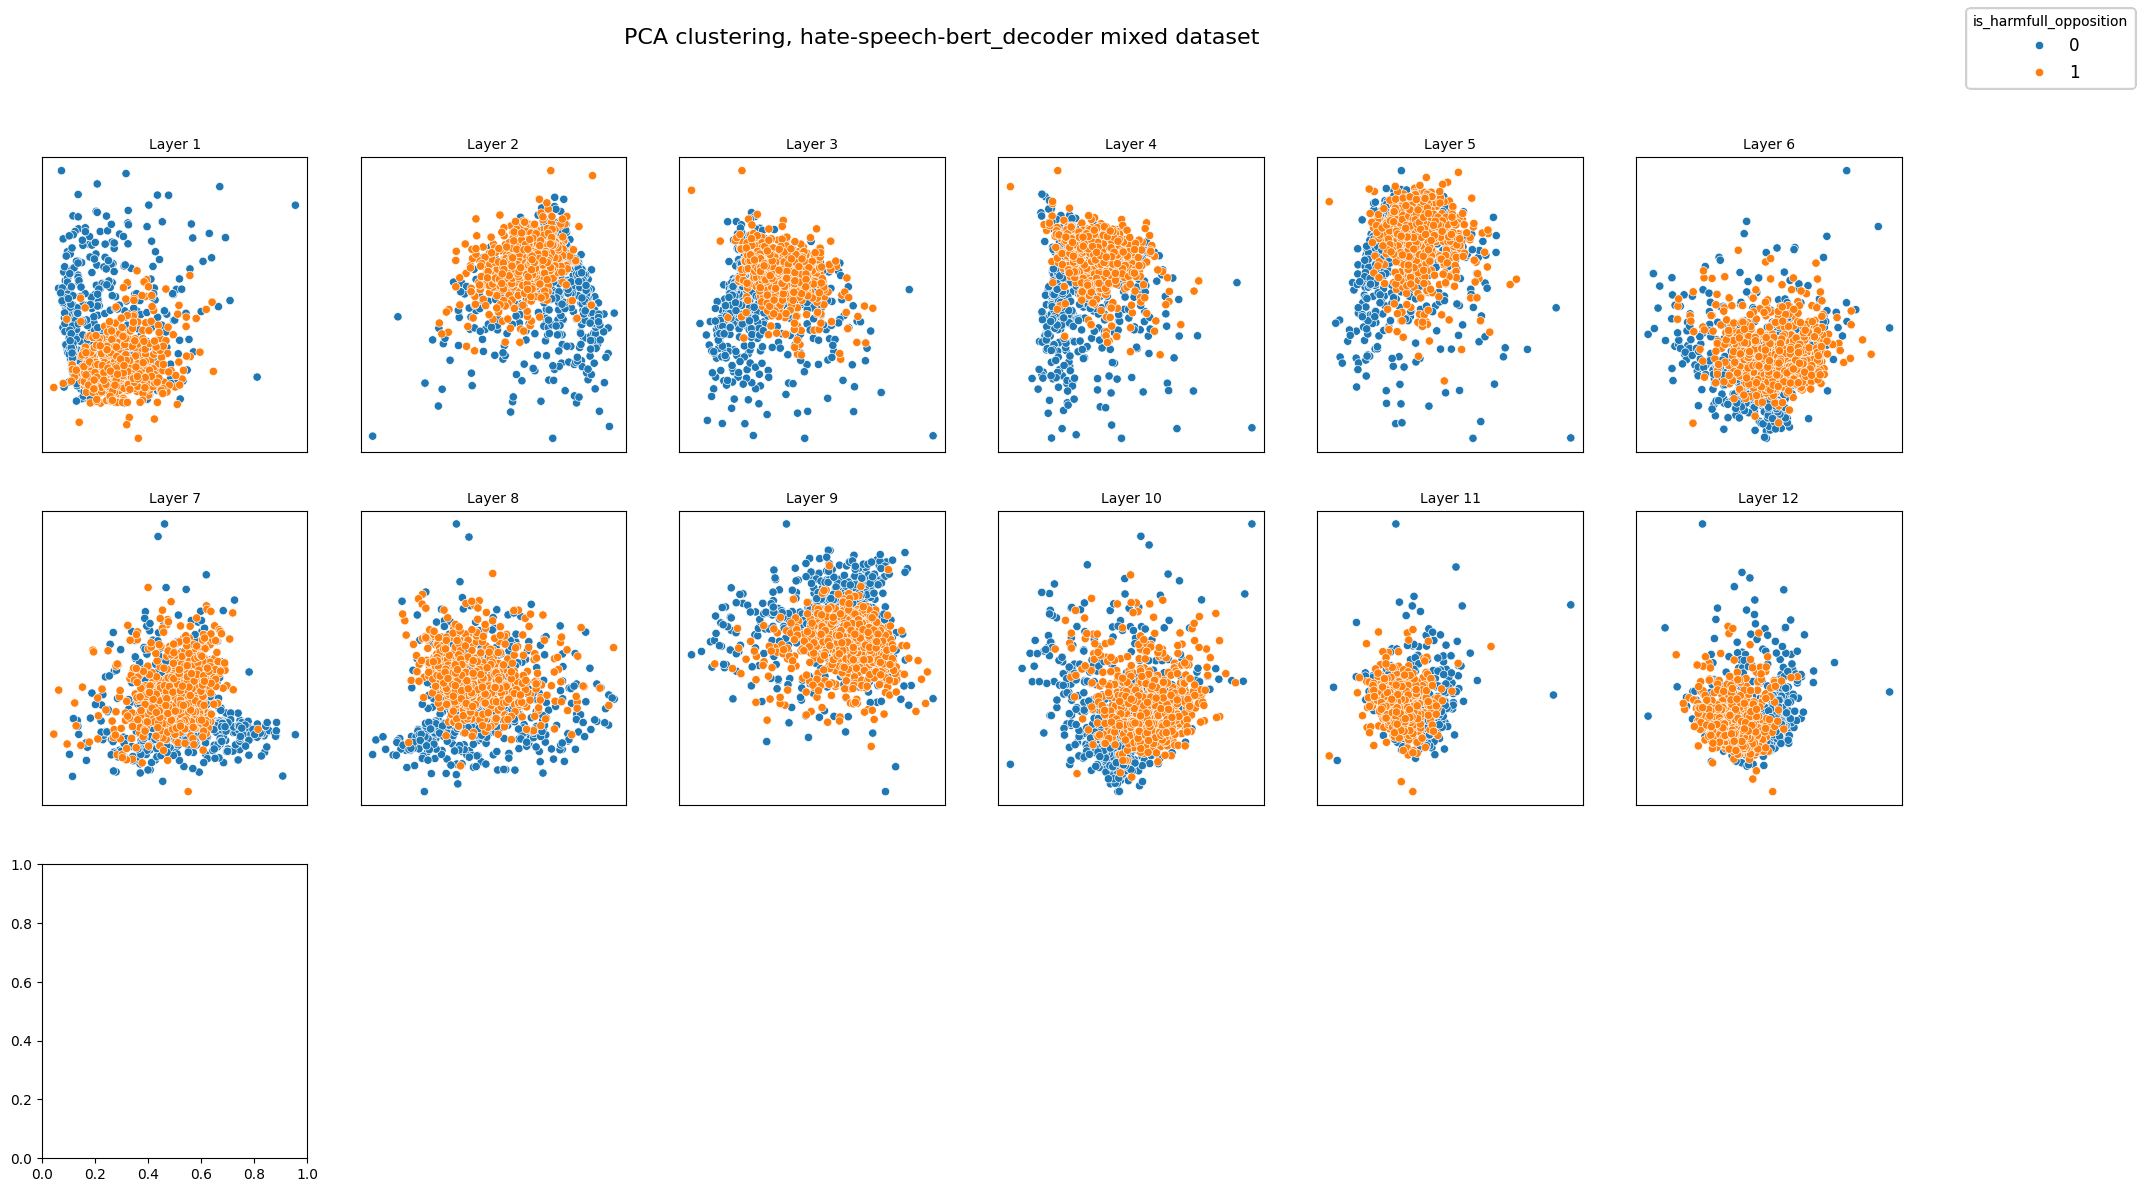

In [79]:
X_pos_mixed_normalized = X_pos_mixed.reshape(-1, X_pos_mixed.shape[-1])         # (512*25, 768)
X_pos_mixed_normalized = normalize(X_pos_mixed_normalized, norm='l2', axis=1).reshape(X_pos_mixed.shape)

X_neg_mixed_normalized = X_neg_mixed.reshape(-1, X_neg_mixed.shape[-1])         # (512*25, 768)
X_neg_mixed_normalized = normalize(X_neg_mixed_normalized, norm='l2', axis=1).reshape(X_neg_mixed.shape)


plot_pca_or_tsne_layerwise(X_pos_mixed_normalized,
                           X_neg_mixed_normalized,
                           hate_total_yes_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title=f'PCA clustering, {MODEL_NAME} mixed dataset')

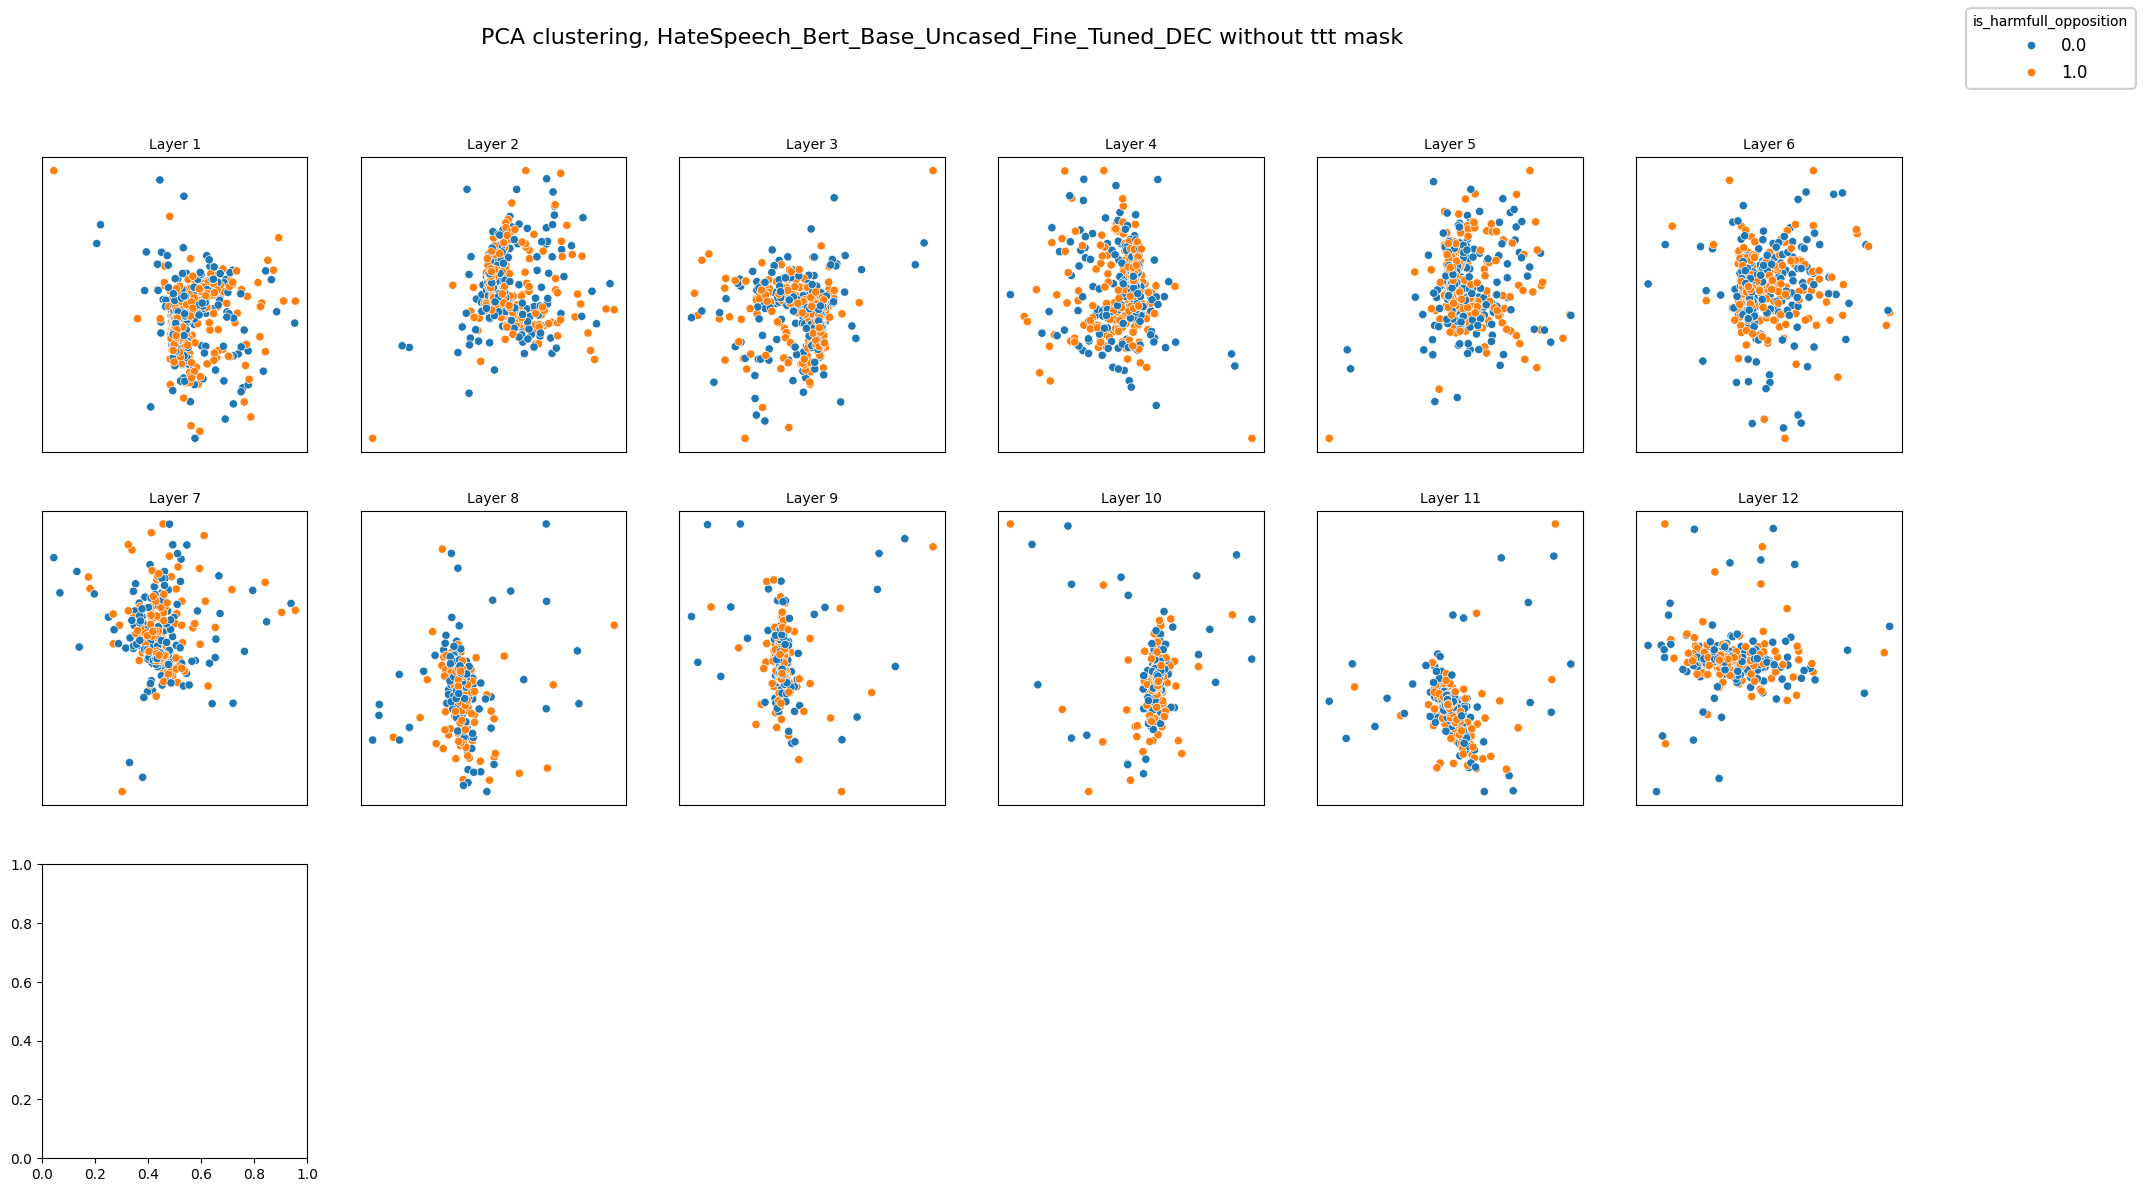

In [ ]:
# X_pos = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_pos_small.npy')
# X_neg = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_neg_small.npy')

X_pos_not_normalized = X_pos_not.reshape(-1, X_pos_not.shape[-1])         # (512*25, 768)
X_pos_not_normalized = normalize(X_pos_not_normalized, norm='l2', axis=1).reshape(X_pos_not.shape)

X_neg_not_normalized = X_neg_not.reshape(-1, X_neg_not.shape[-1])         # (512*25, 768)
X_neg_not_normalized = normalize(X_neg_not_normalized, norm='l2', axis=1).reshape(X_neg_not.shape)


plot_pca_or_tsne_layerwise(X_pos_not_normalized,
                           X_neg_not_normalized,
                           hate_total_not_yes_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title=f'PCA clustering, {MODEL_NAME} not dataset without ttt mask')

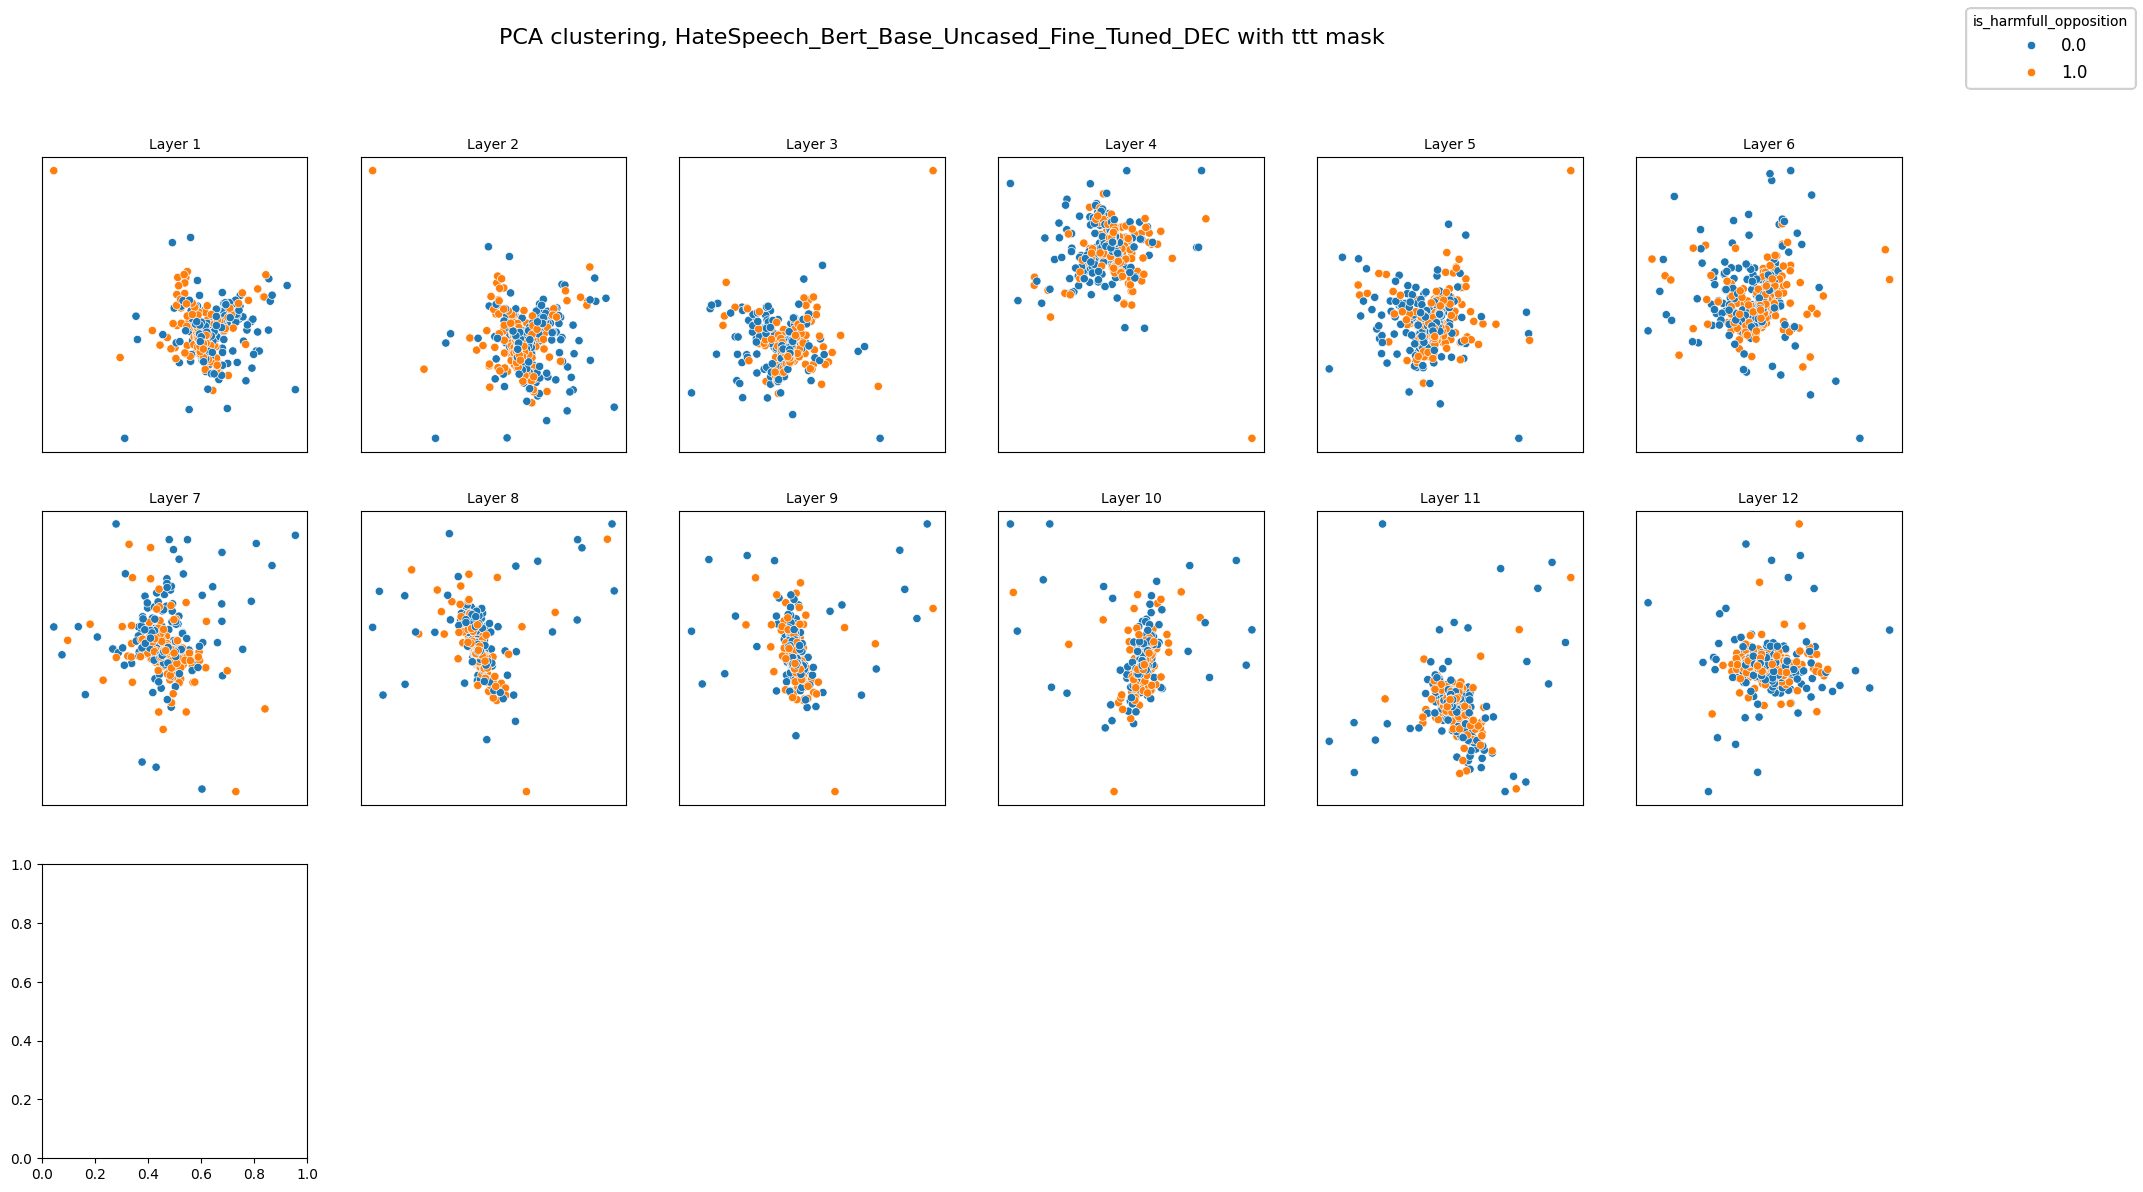

In [ ]:
# X_pos = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_pos_small.npy')
# X_neg = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_neg_small.npy')

X_pos_normalized_rnd_check = X_pos_rnd_check.reshape(-1, X_pos_rnd_check.shape[-1])         # (512*25, 768)
X_pos_normalized_rnd_check= normalize(X_pos_normalized_rnd_check, norm='l2', axis=1).reshape(X_pos_rnd_check.shape)

X_neg_normalized_rnd_check = X_neg_rnd_check.reshape(-1, X_neg_rnd_check.shape[-1])         # (512*25, 768)
X_neg_normalized_rnd_check = normalize(X_neg_normalized_rnd_check, norm='l2', axis=1).reshape(X_neg_rnd_check.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized_rnd_check,
                           X_neg_normalized_rnd_check,
                           hate_not_data_yes_rnd_check['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title=f'PCA clustering, {MODEL_NAME} with ttt mask')

## **5. Find best CCS**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.
To train CCS we need dataset organised as follows:

- first $k = \frac{total-samples}{2}$ are harm statements
- next $k$ samples are safe statements
- each pair indexes are $i, i + \frac{total-samples}{2}$

In [80]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_mixed_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.20, random_state=71, shuffle=True)


# train CCS on normalized states
ccs_mixed_data = train_ccs_on_hidden_states(X_pos_mixed_normalized,
                                        X_neg_mixed_normalized,
                                        hate_total_yes_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

with open(f'ccs_{MODEL_NAME}_mixed_data_results.pkl', 'wb') as f:
    pickle.dump(ccs_mixed_data, f)

Median normalize used
Layer 1/13, CCS accuracy: 0.5381526104417671
Median normalize used
Layer 2/13, CCS accuracy: 0.7469879518072289
Median normalize used
Layer 3/13, CCS accuracy: 0.7349397590361446
Median normalize used
Layer 4/13, CCS accuracy: 0.7349397590361446
Median normalize used
Layer 5/13, CCS accuracy: 0.7309236947791165
Median normalize used
Layer 6/13, CCS accuracy: 0.7269076305220884
Median normalize used
Layer 7/13, CCS accuracy: 0.7108433734939759
Median normalize used
Layer 8/13, CCS accuracy: 0.6265060240963856
Median normalize used
Layer 9/13, CCS accuracy: 0.714859437751004
Median normalize used
Layer 10/13, CCS accuracy: 0.7228915662650602
Median normalize used
Layer 11/13, CCS accuracy: 0.7469879518072289
Median normalize used
Layer 12/13, CCS accuracy: 0.7389558232931727
Median normalize used
Layer 13/13, CCS accuracy: 0.7389558232931727


In [69]:
with open(f'ccs_{MODEL_NAME}_mixed_data_results.pkl', 'wb') as f:
    pickle.dump(ccs_mixed_data, f)

In [ ]:

# train CCS on normalized states
not_ccs = train_ccs_on_hidden_states(X_pos_not_normalized,
                                        X_neg_not_normalized,
                                        hate_not_data_no['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

In [133]:
# train CCS on normalized states
rnd_ccs = train_ccs_on_hidden_states(X_pos_normalized_rnd_check,
                                        X_neg_normalized_rnd_check,
                                        hate_not_data_no['is_harmfull_opposition'],
                                        train_idx,
                                        test_idx,
                                        normalizing='median')

Median normalize used
Layer 1/13, CCS accuracy: 0.5769230769230769
Median normalize used
Layer 2/13, CCS accuracy: 0.6666666666666666
Median normalize used
Layer 3/13, CCS accuracy: 0.6410256410256411
Median normalize used
Layer 4/13, CCS accuracy: 0.6538461538461539
Median normalize used
Layer 5/13, CCS accuracy: 0.6153846153846154
Median normalize used
Layer 6/13, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 7/13, CCS accuracy: 0.5256410256410257
Median normalize used
Layer 8/13, CCS accuracy: 0.5384615384615384
Median normalize used
Layer 9/13, CCS accuracy: 0.5769230769230769
Median normalize used
Layer 10/13, CCS accuracy: 0.5256410256410257
Median normalize used
Layer 11/13, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 12/13, CCS accuracy: 0.5641025641025641
Median normalize used
Layer 13/13, CCS accuracy: 0.5512820512820513


In [ ]:
with open(f'ccs_{MODEL_NAME}_not_without_ttt_data.pkl', 'wb') as f:
    pickle.dump(not_ccs, f)

with open(f'ccs_{MODEL_NAME}_not_with_ttt_data.pkl', 'wb') as f:
    pickle.dump(rnd_ccs, f)

After that, we train the CCS on the selected layer to obtain the probe and its weights.

In [258]:
# from ccs import CCS
# import random

# LAYER_IDX = 4

# X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
# X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# # Train-Test indexes
# X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
# X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

# X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
# X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

# y_train = hate_not_data_no['is_harmfull_opposition'][train_idx]
# y_test  = hate_not_data_no['is_harmfull_opposition'][test_idx]

# # Median normalizing
# X_pos_norm_train -= np.median(X_pos_norm_train)
# X_pos_norm_test -= np.median(X_pos_norm_train)

# X_neg_norm_train -= np.median(X_neg_norm_train)
# X_neg_norm_test -= np.median(X_neg_norm_train)

# # Train CCS without labels first NEG, after POS!
# ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
# ccs.repeated_train()

# # Evaluate
# ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
# print("CCS accuracy: {}".format(ccs_acc))